# Creating a clear cut timelapse with Sentinel 1 data 🎥


**Notes**

- 2018 uses gamma nought while last one used sigma nought?!
- Moisture relou > citation : du coup on a besoin des ombres

> The backscatter from vegetation canopy is affected by vegetation 3D structure and water content (related to biomass) [21]. The ground backscatter at C-band is affected by soil moisture, surface roughness, and terrain topography [22]. The pixel-based detection of deforestation using C-band SAR backscatter time-series can therefore be difficult, as deforestation is not necessarily characterized by a drastic change in backscatter within the disturbed area. Deforested areas may exhibit the same backscatter values as intact forests, for example, after rainfall events. Management practices may also induce misdetections: deforested areas that are cleaned or burnt are easily detectable by their lower backscatter, whereas deforested patches with large branches remaining on the ground may show similar, if not higher, backscatter values than intact forests, because of a branches-ground double-bounce scattering mechanism. Note that the double-bounce also increases with soil moisture.

- Radar Change Ratio: $RCR_i = M_a/M_b$ with a linear scale, or $RCR_i = M_a-M_b$ on a decibel scale.
- 967 validation clear cuts => NOT OPEN SOURCE :c
- Using [U-TAE](https://github.com/VSainteuf/utae-paps) (U-NEXT x Transformers) to detect clear cuts: [Deforestation detection in the Amazon with sentinel-1 SAR image time series](https://www.zora.uzh.ch/id/eprint/254908/1/ZORA_isprs_annals_X_1_W1_2023_835_2023.pdf)
- VH/VV to limit the moisture noise?
- Mix DESCENDING/ASCENDING orbits or not?
- Check distribution of delta days for S1A
- Tropicsco uses VV, Sufosat uses VH?! According to 2018, they perform about the same.
- Use Sufosat Near Real Time (NRT) labels as ground truths? We could remove false positives using validation maps (e.g., yearly height map)
- Repo étudiant pour reproduire 2018: https://github.com/chloeskt/SAR_deforestation_detection

**Three tracks**

- Validation de SUFOSAT à partir d'autres sources (Global Forest Watch) ou carte de hauteur.
- Détection des clear cuts
- Prédiction de métriques pré-coupe pour savoir si celle-ci est considérée comme légale ou non et ajouter des données pour la plainte.


In [1]:
import math

import cv2
import ee
import geemap
import matplotlib.pyplot as plt
import numpy as np
import rasterio

In [2]:
ee.Authenticate()
ee.Initialize()

## Area Of Interest

https://www.google.com/maps?q=44.62325,-0.77319

|         Google Earth         |         SUFOSAT         |
| :--------------------------: | :---------------------: |
| ![](images/google_earth.png) | ![](images/sufosat.png) |


In [3]:
# Define the bounding box coordinates
minx, maxx, miny, maxy = (-0.78214, -0.76696, 44.614897, 44.63059)

# Define the area of interest (AOI) as a rectangle
aoi = ee.Geometry.Rectangle([minx, miny, maxx, maxy])

# Create a map centered on the AOI
Map: geemap.Map = geemap.Map(center=[(miny + maxy) / 2, (minx + maxx) / 2], zoom=15)

# Display the map with Google Earth basemap (satellite view by default)
Map.add_basemap("SATELLITE")

# Add the AOI to the map
Map.addLayer(aoi, {"color": "red"}, "AOI", opacity=0.5)

# Display the map without interactivity features
Map.dragging = False
Map.scroll_wheel_zoom = False
Map.touch_zoom = False
Map.double_click_zoom = False
Map.box_zoom = False
Map.keyboard = False
Map.clear_controls()
Map

Map(box_zoom=False, center=[44.6227435, -0.77455], crs={'name': 'EPSG3857', 'custom': False}, default_style=Ma…

## Downloading images


### Two provider options to download images: Google Earth vs Copernicus

|               Google Earth                |               Copernicus                |
| :---------------------------------------: | :-------------------------------------: |
| ![](images/option_google_earth_gamma.png) | ![](images/option_copernicus_gamma.png) |

For some reason, Copernicus images seem more precise.
However, I started using Google Earth Engine API so we'll stick with it for now.


### Sentinel-1 preprocessing by Google Earth Engine

See preprocessing documentation [here](https://developers.google.com/earth-engine/guides/sentinel1).

TL;DR:

- Sentinel-1 data is radiometrically calibrated to sigma nought.
- Backscatter values are in decibels (dB).
- Data is preprocessed and orthorectified.


### Listing images to download


In [51]:
s1_collection: ee.ImageCollection = (
    ee.ImageCollection("COPERNICUS/S1_GRD")  # Ground-Range Detected
    .filterBounds(aoi)  # Filter by Area of Interest
    .filterDate("2024-01-01", "2024-12-31")  # Filter by date range
    .filter(ee.Filter.listContains("transmitterReceiverPolarisation", "VH"))  # VH polarization
    .filter(ee.Filter.eq("instrumentMode", "IW"))  # Interferometric Wide swath mode
    .filter(ee.Filter.eq("platform_number", "A"))  # Sentinel-1A
    .filter(
        ee.Filter.Or(
            ee.Filter.eq("orbitProperties_pass", "ASCENDING"),
            ee.Filter.eq("orbitProperties_pass", "DESCENDING"),
        )
    )  # Include both ascending and descending orbits
    .select(["VH", "angle"])  # Need angle to convert to Gamma nought
)

print(f"Number of images found: {s1_collection.size().getInfo()}")

Number of images found: 90


In [52]:
# Information about the first image
s1_collection.first().getInfo()

{'type': 'Image',
 'bands': [{'id': 'VH',
   'data_type': {'type': 'PixelType', 'precision': 'double'},
   'dimensions': [29527, 21525],
   'crs': 'EPSG:32630',
   'crs_transform': [10, 0, 418857.6650754043, 0, -10, 5072149.686266462]},
  {'id': 'angle',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'dimensions': [21, 10],
   'crs': 'EPSG:32630',
   'crs_transform': [-13101.70255854167,
    -3324.70744088199,
    708700.7136158249,
    2109.961864989251,
    -20104.608609532006,
    5026798.796882617]}],
 'version': 1741532407209510.0,
 'id': 'COPERNICUS/S1_GRD/S1A_IW_GRDH_1SDV_20240104T061714_20240104T061739_051953_0646FC_DC22',
 'properties': {'SNAP_Graph_Processing_Framework_GPF_vers': '9.0.0',
  'SLC_Processing_facility_org': 'ESA',
  'SLC_Processing_facility_country': 'Italy',
  'GRD_Post_Processing_facility_org': 'ESA',
  'transmitterReceiverPolarisation': ['VV', 'VH'],
  'GRD_Post_Processing_start': 1704351102621,
  'sliceNumber': 20,
  'GRD_Post_Processing_fac

### Convert Decibels to Linear Scale

We should use the linear scale instead of the decibel if we want to perform interpolation or smoothing


In [38]:
def to_linear(image: ee.image.Image) -> ee.image.Image:
    """Convert Sentinel-1 backscatter from dB to linear scale."""
    return image.addBands(
        ee.Image(10).pow(image.select("VH").divide(10)).rename("VH"), overwrite=True
    )


s1_collection: ee.ImageCollection = s1_collection.map(to_linear)

### Two calibration options: Sigma vs Gamma

<details>
<summary>Google Earth Engine code to compare calibration options</summary>

```javascript
var image = ee.Image(
  "COPERNICUS/S1_GRD/S1A_IW_GRDH_1SDV_20240826T060900_20240826T060925_055380_06C110_D56A"
);

print(Math.PI / 180.0);

function toGamma0(image) {
  return image.select("VH").divide(
    image
      .select("angle")
      .multiply(Math.PI / 180.0)
      .cos()
  );
}

var before = image.select("VH");
var after = toGamma0(image);

Map.setCenter(-0.77319, 44.62325);
Map.addLayer(before, { min: -30, max: 0 }, "Sigma_0");
Map.addLayer(after, { min: -30, max: 0 }, "Gamma_0");
```

</details>
<br>

|            Sigma             |            Gamma             |
| :--------------------------: | :--------------------------: |
| ![](images/option_sigma.png) | ![](images/option_gamma.png) |

The clear cut is much more visible to the eye with gamma calibration.
However, sigma seems to be more popular / recommended for most use cases...
In the "Use of the SAR Shadowing Effect for Deforestation Detection with Sentinel-1 Time Series" paper, they seem to use gamma though, so we'll go with gamma for now.


In [53]:
def to_gamma(image: ee.image.Image) -> ee.image.Image:
    """Convert Sentinel-1 backscatter from Sigma nought to Gamma nought."""
    return image.select("VH").divide(image.select("angle").multiply(math.pi / 180.0).cos())


s1_collection: ee.ImageCollection = s1_collection.map(to_gamma).select("VH")

### Reproject to LAMBERT93 and align the images on the same grid


In [54]:
def reproject_and_align(image: ee.image.Image) -> ee.image.Image:
    """Reprojects Sentinel-1 image to LAMBERT93 and aligns it to a common grid."""
    return (
        image.reproject(
            crs="EPSG:2154",  # LAMBERT93
            scale=10,  # 10 meters resolution
        )
        # Bilinear resampling computes pixel value as a weighted average of the four nearest neighbors.
        # Best for continuous data like Sentinel-1 backscatter.
        # .resample("bilinear")
    )


s1_collection: ee.ImageCollection = s1_collection.map(reproject_and_align)

### Stacking the images from the collection into a single image with multiple bands


In [55]:
stacked_image = s1_collection.toBands()  # Convert collection to a multi-band image
stacked_image.getInfo()

{'type': 'Image',
 'bands': [{'id': 'S1A_IW_GRDH_1SDV_20240104T061714_20240104T061739_051953_0646FC_DC22_VH',
   'data_type': {'type': 'PixelType', 'precision': 'double'},
   'crs': 'EPSG:2154',
   'crs_transform': [10, 0, 0, 0, -10, 0]},
  {'id': 'S1A_IW_GRDH_1SDV_20240111T060902_20240111T060927_052055_064A7D_F8F2_VH',
   'data_type': {'type': 'PixelType', 'precision': 'double'},
   'crs': 'EPSG:2154',
   'crs_transform': [10, 0, 0, 0, -10, 0]},
  {'id': 'S1A_IW_GRDH_1SDV_20240112T175616_20240112T175641_052077_064B4D_6CC8_VH',
   'data_type': {'type': 'PixelType', 'precision': 'double'},
   'crs': 'EPSG:2154',
   'crs_transform': [10, 0, 0, 0, -10, 0]},
  {'id': 'S1A_IW_GRDH_1SDV_20240116T061713_20240116T061738_052128_064CFD_938B_VH',
   'data_type': {'type': 'PixelType', 'precision': 'double'},
   'crs': 'EPSG:2154',
   'crs_transform': [10, 0, 0, 0, -10, 0]},
  {'id': 'S1A_IW_GRDH_1SDV_20240123T060902_20240123T060927_052230_06506C_6AD5_VH',
   'data_type': {'type': 'PixelType', 'pre

## Download the images

You can follow the task progress in Google Cloud console: https://console.cloud.google.com/earth-engine/tasks


In [56]:
# Export the image to Google Drive as a GeoTIFF
export_task = ee.batch.Export.image.toDrive(
    image=stacked_image,
    description="clear_cut_time_series_vh_linear_gamma_nought_lambert93",
    folder="Google Earth",
    fileFormat="GeoTIFF",
    region=aoi,
    formatOptions={"cloudOptimized": True},
)
export_task.start()

In [45]:
export_task.status()

{'state': 'RUNNING',
 'description': 'clear_cut_time_series_vh_linear_gamma_nought_lambert93',
 'priority': 100,
 'creation_timestamp_ms': 1741532137731,
 'update_timestamp_ms': 1741532206880,
 'start_timestamp_ms': 1741532150630,
 'task_type': 'EXPORT_IMAGE',
 'attempt': 1,
 'batch_eecu_usage_seconds': 10.747,
 'id': '65ULRSDSF2BQBROI5SAO5USX',
 'name': 'projects/485600168859/operations/65ULRSDSF2BQBROI5SAO5USX'}

## Health check: plot one of the bands


Number of bands: 90
Bands size: 130 x 181
CRS EPSG: 2154


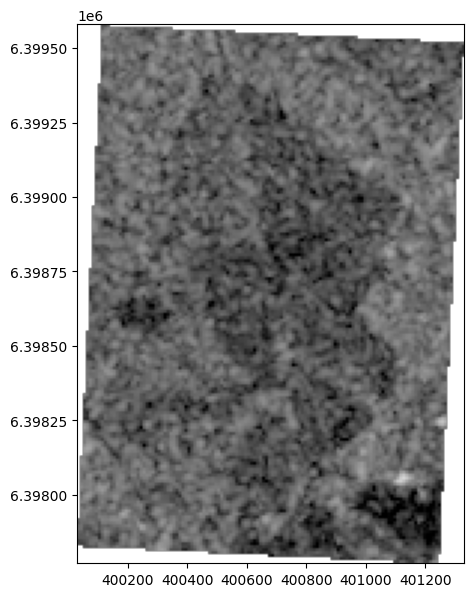

In [57]:
band_name = "S1A_IW_GRDH_1SDV_20240826T060900_20240826T060925_055380_06C110_D56A_constant"

with rasterio.open("../../data/clear_cut_time_series.tif") as src:
    # Profile
    profile = src.profile
    print("Number of bands:", profile["count"])
    print(f"Bands size: {profile['width']} x {profile['height']}")
    print(f"CRS EPSG: {src.crs.to_epsg()}")

    # Data
    band_id = list(src.descriptions).index(band_name) + 1
    data = src.read(band_id)

    # Get the bounds
    left, bottom, right, top = src.bounds

plt.figure(figsize=(7, 7))
# Plot in decibel scale with vmin/vmax for better readability
plt.imshow(
    10 * np.log10(data), cmap="gray", vmin=-30, vmax=0, extent=[left, right, bottom, top]
)
plt.show()

Number of bands: 90
Bands size: 130 x 181
CRS EPSG: 2154


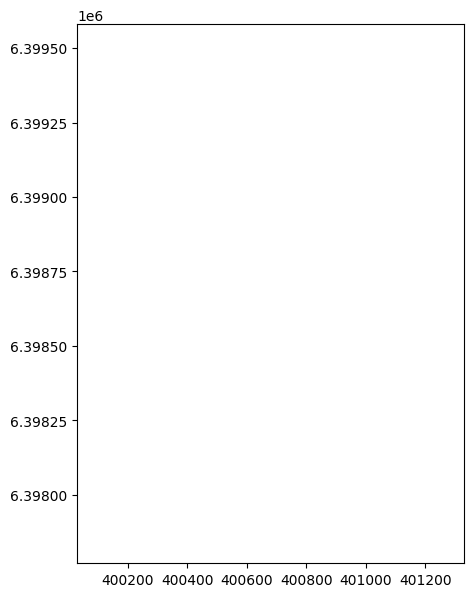

In [58]:
band_name = "S1A_IW_GRDH_1SDV_20240826T060900_20240826T060925_055380_06C110_D56A_VH"

with rasterio.open(
    "../../data/clear_cut_time_series_vh_linear_gamma_nought_lambert93.tif"
) as src:
    # Profile
    profile = src.profile
    print("Number of bands:", profile["count"])
    print(f"Bands size: {profile['width']} x {profile['height']}")
    print(f"CRS EPSG: {src.crs.to_epsg()}")

    # Data
    band_id = list(src.descriptions).index(band_name) + 1
    data = src.read(band_id)

    # Get the bounds
    left, bottom, right, top = src.bounds

plt.figure(figsize=(7, 7))
# Plot in decibel scale with vmin/vmax for better readability
plt.imshow(
    10 * np.log10(data), cmap="gray", vmin=-30, vmax=0, extent=[left, right, bottom, top]
)
plt.show()

It looks like we're getting the same image back, good news!
Now, we can process the images to reduce the speckle noise.


## Reducing the speckle noise


- Temporal filtering
- 3x3 smoothing / Lee filter
- Plot timelapse (cmap with min max + decibel scale)


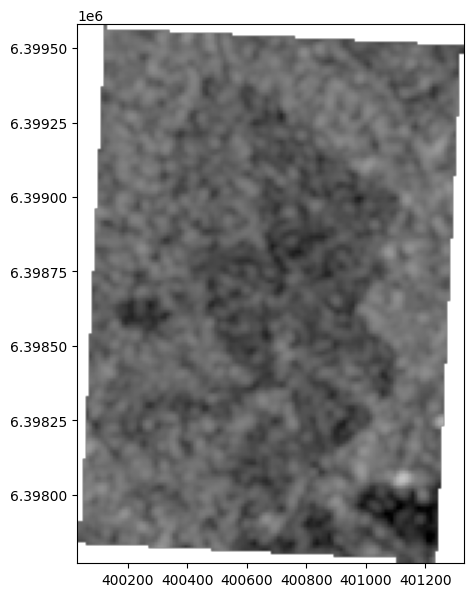

In [ ]:
# Apply a 3×3 Mean Filter
kernel = np.ones((3, 3), np.float32) / 9.0
smoothed_data = cv2.filter2D(data, -1, kernel)

plt.figure(figsize=(7, 7))
# Plot in decibel scale with vmin/vmax for better readability
plt.imshow(
    10 * np.log10(smoothed_data),
    cmap="gray",
    vmin=-30,
    vmax=0,
    extent=[left, right, bottom, top],
)
plt.show()

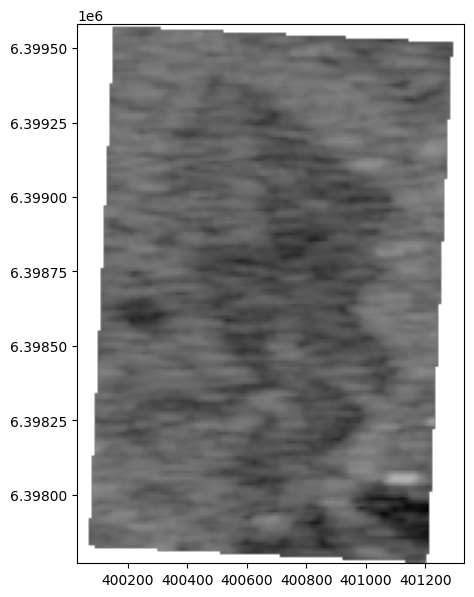

In [ ]:
# Define a simple moving average filter (for demonstration)
def apply_speckle_filter(image, size=3):
    kernel = np.ones((size, size)) / (size * size)
    return np.convolve(image.flatten(), kernel.flatten(), mode="same").reshape(image.shape)


# Apply the filter
smoothed_data = apply_speckle_filter(data)

plt.figure(figsize=(7, 7))
# Plot in decibel scale with vmin/vmax for better readability
plt.imshow(
    10 * np.log10(smoothed_data),
    cmap="gray",
    vmin=-30,
    vmax=0,
    extent=[left, right, bottom, top],
)
plt.show()

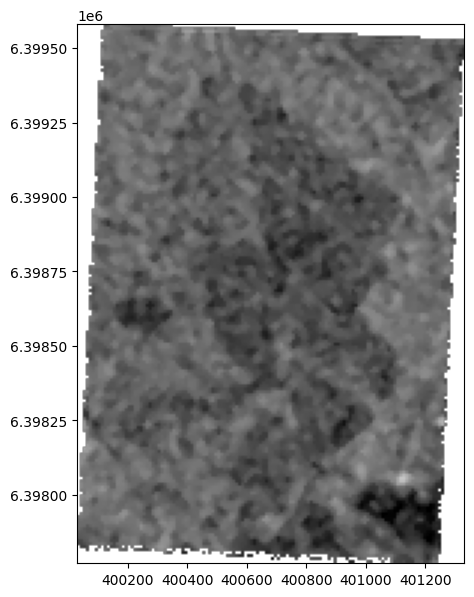

In [82]:
from scipy.ndimage import median_filter

smoothed_data = median_filter(data, size=3)

plt.figure(figsize=(7, 7))
# Plot in decibel scale with vmin/vmax for better readability
plt.imshow(
    10 * np.log10(smoothed_data),
    cmap="gray",
    vmin=-30,
    vmax=0,
    extent=[left, right, bottom, top],
)
plt.show()